In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#reading in quarterly data, merged with financials
df = pd.read_csv('thinknum_w_financial_data.csv',low_memory=False)

In [3]:
df.loc[df['xoprq']<0,'xoprq'] = 0 #removing negative values of operational expense
df.head()

,Unnamed: 0,year,q,ticker,titles,counts,exchange,tic,gvkey,datadate,...,datafqtr,niq,nopiq,revtq,spce12,xoprq,nimy,exchg,costat,mkvaltq
0,0,2018,3,nasdaq:adap,Quality Assurance Specialist,1,nasdaq,adap,23574,20180930,...,2018Q3,5.242,-1.643,40.792,NaN,31.865,NaN,14.0,A,NaN
1,1,2018,3,nasdaq:adap,Paralegal,1,nasdaq,adap,23574,20180930,...,2018Q3,5.242,-1.643,40.792,NaN,31.865,NaN,14.0,A,NaN
2,2,2018,3,nasdaq:adap,"Associate Scientist , Manufacturing Sciences a...",1,nasdaq,adap,23574,20180930,...,2018Q3,5.242,-1.643,40.792,NaN,31.865,NaN,14.0,A,NaN
3,3,2018,3,nasdaq:adap,"Director, Clinical Scientist",1,nasdaq,adap,23574,20180930,...,2018Q3,5.242,-1.643,40.792,NaN,31.865,NaN,14.0,A,NaN
4,4,2018,3,nasdaq:adap,"Associate Director, IT Compliance",1,nasdaq,adap,23574,20180930,...,2018Q3,5.242,-1.643,40.792,NaN,31.865,NaN,14.0,A,NaN


In [4]:
# df2 aggregates job posting volume, revenue, operational expense, and market value
# at the quarterly level for each company
df2 = df.groupby(['conm','year','q'],as_index=False).agg({'counts':sum,
    'revtq':np.mean,'xoprq':np.mean,'mkvaltq':np.mean})
df2 = df2.loc[df2.duplicated(['conm'],keep=False),:]
print(df2['conm'].nunique()) #1957 unique companies
df2[['year','q']].drop_duplicates().sort_values(['year','q']) #quarterly from Q1_2016 - Q3_2018

1957


,year,q
6,2016,1
7,2016,2
8,2016,3
9,2016,4
10,2017,1
0,2017,2
1,2017,3
2,2017,4
3,2018,1
4,2018,2


In [5]:
# creating derivatives from each of the fours variables
for i in ['counts','revtq', 'xoprq', 'mkvaltq']:
    # leading values for 4 quarter in the future
    df2[i+'_f1'] = df2.groupby('conm')[i].shift(-1)
    for j in range(2,5):
        df2[i+'_f'+str(j)] = df2.groupby('conm')[i].shift(-1*j)
    # natural logs of each variable
    df2['ln_'+i] = np.log(1+df2[i])
    # growth rates for 4 quarter in the future
    df2[i+'_g1'] = np.log(1+df2[i+'_f1'])-np.log(1+df2[i])
    for j in range(2,5):
        df2[i+'_g'+str(j)] = np.log(1+df2[i+'_f'+str(j)])-np.log(1+df2[i+'_f'+str(j-1)])
    # mean differences of the natural log by company
    df2['ln_'+i+'_d'] = df2['ln_'+i] - df2.groupby(['conm'])['ln_'+i].transform(np.mean)

l_df2 = [] # a list to store parameters
err_df2 = [] # a list to store standard errors
for j in ['ln_counts_d']:
    for i in ['ln_xoprq_d','ln_revtq_d','ln_mkvaltq_d']:
        l_df2.append(smf.ols(i+'~'+j,data=df2).fit().params[j])
        err_df2.append(smf.ols(i+'~'+j,data=df2).fit().HC0_se[j])
        # parameters and t-statisics from each regression
        print(j,i,smf.ols(i+'~'+j,data=df2).fit().params[j],smf.ols(i+'~'+j,data=df2).fit().tvalues[j])

# creating a new data dataframe to generate plots from
plot1 = pd.DataFrame({'coef':l_df2},
              index=['Expense','Revenue','Mkt Cap'])

ln_counts_d ln_xoprq_d 0.03080106638778239 15.73238963236958
ln_counts_d ln_revtq_d 0.030605665533615874 10.1359936871931
ln_counts_d ln_mkvaltq_d 0.046481353427346606 15.803619502895762


[Text(0,0,'0%'),
 Text(0,0,'1%'),
 Text(0,0,'2%'),
 Text(0,0,'3%'),
 Text(0,0,'4%'),
 Text(0,0,'5%'),
 Text(0,0,'6%')]

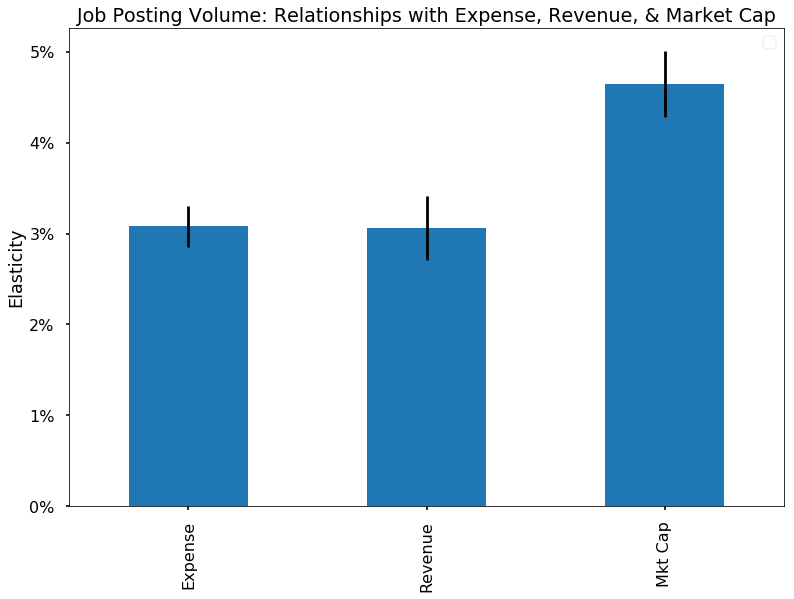

In [6]:
plt.style.use('seaborn-poster')
fig, ax = plt.subplots()
plot1.plot.bar(ax=ax,yerr=[err_df2])
ax.set_title('Job Posting Volume: Relationships with Expense, Revenue, & Market Cap')
ax.set_ylabel('Elasticity')
ax.legend([]) 

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

In [7]:
l_growth = [] # list to store parameters
l_err = [] # list to store standard errors
for j in ['counts_g1']:
    for i in ['xoprq_g2','xoprq_g3','xoprq_g4',
              'revtq_g2','revtq_g3','revtq_g4']:
        l_growth.append(smf.ols(i+'~'+j,data=df2).fit().params[j])
        l_err.append(smf.ols(i+'~'+j,data=df2).fit().HC0_se[j])
        print(j,i,smf.ols(i+'~'+j,data=df2).fit().params[j],smf.ols(i+'~'+j,data=df2).fit().tvalues[j])

plot2 = pd.DataFrame({'effect':l_growth,
              'type':['expense','expense','expense','revenue','revenue','revenue'],
              'lead':[1,2,3,1,2,3]}).pivot_table(
    index='lead',columns='type')

counts_g1 xoprq_g2 0.008713341712624703 3.390164671629369
counts_g1 xoprq_g3 0.00014488703947110695 0.04712512678543947
counts_g1 xoprq_g4 0.004942393533959517 1.3132245513218206
counts_g1 revtq_g2 0.007713722704566223 2.1658904287407705
counts_g1 revtq_g3 -0.0034812277735839035 -0.858552544944565
counts_g1 revtq_g4 0.008432739984190373 1.7644804143071025


[Text(0,0,'-1.0%'),
 Text(0,0,'-0.5%'),
 Text(0,0,'0.0%'),
 Text(0,0,'0.5%'),
 Text(0,0,'1.0%'),
 Text(0,0,'1.5%')]

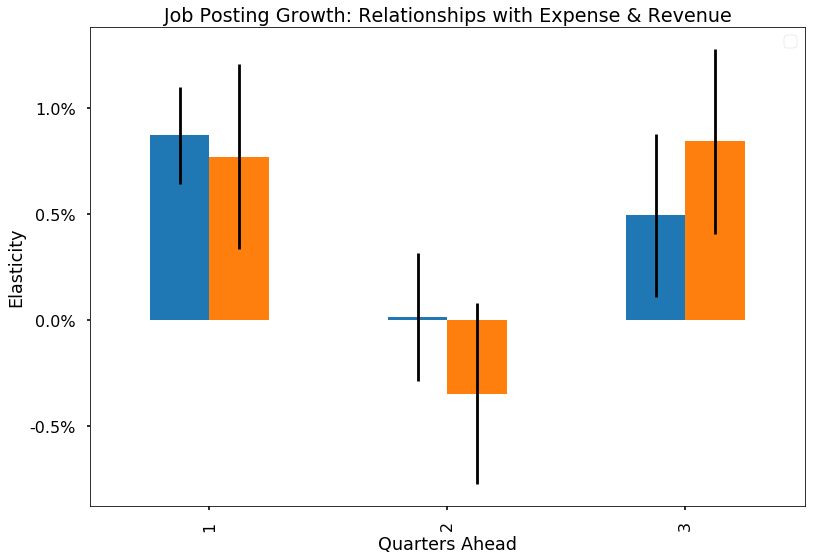

In [8]:
fig, ax = plt.subplots()
plot2.plot.bar(ax=ax,yerr=[l_err[:3],l_err[3:]])
ax.set_title('Job Posting Growth: Relationships with Expense & Revenue')
ax.set_ylabel('Elasticity')
ax.set_xlabel('Quarters Ahead')
ax.legend([]) 

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

In [9]:
# text cleaning to filter jobs based on title
df['titles'] = df['titles'].str.lower()
df['titles'].fillna('missing',inplace=True)

#seniority

df['senior'] = 0
senior_words = ['senior','manag','cheif','chief','ceo','cto','vp','vice','direct','princi','executive','mgr','head']
non = ['assistant','asst','service','office','branch','quality']
for i in senior_words:
    df.loc[df['titles'].str.contains(i),'senior'] = 1
for i in non:
    df.loc[df['titles'].str.contains(i),'senior'] = 0

#product

df['product_engineering'] = 0
prod = ['engine','product','data scie','developer','tech','supervi','design','creat','design','program','sde','web']
non = ['sales','recruit']
for i in prod:
    df.loc[df['titles'].str.contains(i),'product_engineering'] = 1
for i in non:
    df.loc[df['titles'].str.contains(i),'product_engineering'] = 0
    
#sales    
    
df['sales'] = 0
sales = ['sales','customer','represen','agent','account','marketin','event','social',
        'brand','ambass','relations','business dev','relationship']
non = ['accounting','accountant']
for i in sales:
    df.loc[df['titles'].str.contains(i),'sales'] = 1
for i in non:
    df.loc[df['titles'].str.contains(i),'sales'] = 0

In [10]:
#replicating analyses for subsets of the dataframe based on seniority
l_sen = []
err_sen = []

df_senior = df.loc[df['senior']==1,:].groupby(['conm','year','q'],as_index=False).agg({'counts':sum,
    'revtq':np.mean,
        'xoprq':np.mean,'mkvaltq':np.mean})
df_senior = df_senior.loc[df_senior.duplicated(['conm'],keep=False),:]
for i in ['counts','revtq', 'xoprq', 'mkvaltq']:
    df_senior[i+'_f1'] = df_senior.groupby('conm')[i].shift(-1)
    for j in range(2,5):
        df_senior[i+'_f'+str(j)] = df_senior.groupby('conm')[i].shift(-1*j)
    df_senior['ln_'+i] = np.log(1+df_senior[i])
    df_senior[i+'_g1'] = np.log(1+df_senior[i+'_f1'])-np.log(1+df_senior[i])
    for j in range(2,5):
        df_senior[i+'_g'+str(j)] = np.log(1+df_senior[i+'_f'+str(j)])-np.log(1+df_senior[i+'_f'+str(j-1)])
    df_senior['ln_'+i+'_d'] = df_senior['ln_'+i] - df_senior.groupby(['conm'])['ln_'+i].transform(np.mean)
for j in ['ln_counts_d']:
    for i in ['ln_xoprq_d','ln_revtq_d','ln_mkvaltq_d']:
        l_sen.append(smf.ols(i+'~'+j,data=df_senior).fit().params[j])
        err_sen.append(smf.ols(i+'~'+j,data=df_senior).fit().HC0_se[j])
        print(j,i,smf.ols(i+'~'+j,data=df_senior).fit().params[j],smf.ols(i+'~'+j,data=df_senior).fit().tvalues[j])

l_jun = []
err_jun = []

df_junior = df.loc[df['senior']==0,:].groupby(['conm','year','q'],as_index=False).agg({'counts':sum,
    'revtq':np.mean,
        'xoprq':np.mean,'mkvaltq':np.mean})
df_junior = df_junior.loc[df_junior.duplicated(['conm'],keep=False),:]
for i in ['counts','revtq', 'xoprq', 'mkvaltq']:
    df_junior[i+'_f1'] = df_junior.groupby('conm')[i].shift(-1)
    for j in range(2,5):
        df_junior[i+'_f'+str(j)] = df_junior.groupby('conm')[i].shift(-1*j)
    df_junior['ln_'+i] = np.log(1+df_junior[i])
    df_junior[i+'_g1'] = np.log(1+df_junior[i+'_f1'])-np.log(1+df_junior[i])
    for j in range(2,5):
        df_junior[i+'_g'+str(j)] = np.log(1+df_junior[i+'_f'+str(j)])-np.log(1+df_junior[i+'_f'+str(j-1)])
    df_junior['ln_'+i+'_d'] = df_junior['ln_'+i] - df_junior.groupby(['conm'])['ln_'+i].transform(np.mean)
for j in ['ln_counts_d']:
    for i in ['ln_xoprq_d','ln_revtq_d','ln_mkvaltq_d']:
        l_jun.append(smf.ols(i+'~'+j,data=df_junior).fit().params[j])
        err_jun.append(smf.ols(i+'~'+j,data=df_junior).fit().HC0_se[j])
        print(j,i,smf.ols(i+'~'+j,data=df_junior).fit().params[j],smf.ols(i+'~'+j,data=df_junior).fit().tvalues[j])


plot3 = pd.DataFrame({'senior':l_sen,
              'junior':l_jun},
              index=['Expense','Revenue','Mkt Cap'])

ln_counts_d ln_xoprq_d 0.04175132449534184 18.330879050168246
ln_counts_d ln_revtq_d 0.04512075017954845 12.785874654262615
ln_counts_d ln_mkvaltq_d 0.057510838910787565 16.702024967634543
ln_counts_d ln_xoprq_d 0.03195916728962225 16.03429986289617
ln_counts_d ln_revtq_d 0.03339451553751843 10.990860611310042
ln_counts_d ln_mkvaltq_d 0.04725080559308964 15.76956979942645


[Text(0,0,'0%'),
 Text(0,0,'1%'),
 Text(0,0,'2%'),
 Text(0,0,'3%'),
 Text(0,0,'4%'),
 Text(0,0,'5%'),
 Text(0,0,'6%'),
 Text(0,0,'7%')]

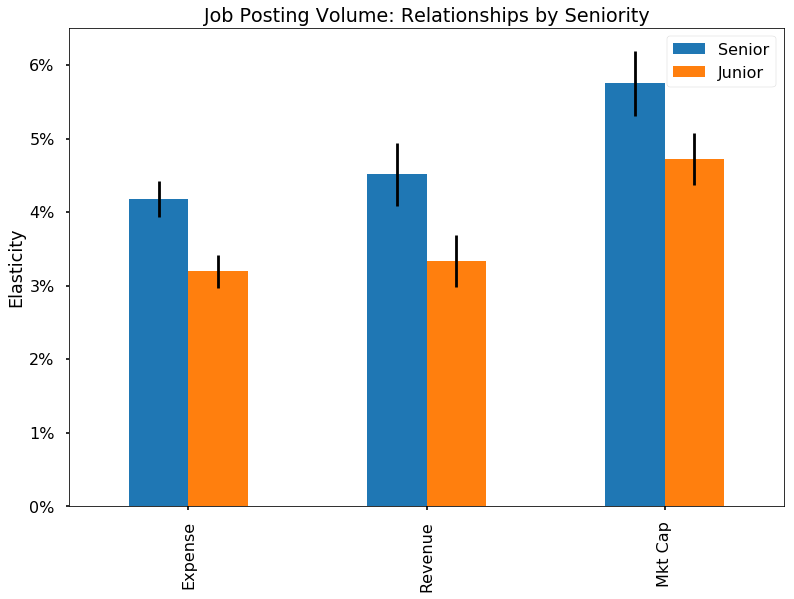

In [11]:
fig, ax = plt.subplots()
plot3.plot.bar(ax=ax,yerr=[err_sen,err_jun])
ax.set_title('Job Posting Volume: Relationships by Seniority')
ax.set_ylabel('Elasticity')
ax.legend(['Senior','Junior']) 

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

In [12]:
#replicating analyses for subsets of the dataframe based on job role
l_prod = []
err_prod = []

df_prod = df.loc[df['product_engineering']==1,:].groupby(['conm','year','q'],as_index=False).agg({'counts':sum,
    'revtq':np.mean,
        'xoprq':np.mean,'mkvaltq':np.mean})
df_prod = df_prod.loc[df_prod.duplicated(['conm'],keep=False),:]
for i in ['counts','revtq', 'xoprq', 'mkvaltq']:
    df_prod[i+'_f1'] = df_prod.groupby('conm')[i].shift(-1)
    for j in range(2,5):
        df_prod[i+'_f'+str(j)] = df_prod.groupby('conm')[i].shift(-1*j)
    df_prod['ln_'+i] = np.log(1+df_prod[i])
    df_prod[i+'_g1'] = np.log(1+df_prod[i+'_f1'])-np.log(1+df_prod[i])
    for j in range(2,5):
        df_prod[i+'_g'+str(j)] = np.log(1+df_prod[i+'_f'+str(j)])-np.log(1+df_prod[i+'_f'+str(j-1)])
    df_prod['ln_'+i+'_d'] = df_prod['ln_'+i] - df_prod.groupby(['conm'])['ln_'+i].transform(np.mean)
for j in ['ln_counts_d']:
    for i in ['ln_xoprq_d','ln_revtq_d','ln_mkvaltq_d']:
        l_prod.append(smf.ols(i+'~'+j,data=df_prod).fit().params[j])
        err_prod.append(smf.ols(i+'~'+j,data=df_prod).fit().HC0_se[j])
        print(j,i,smf.ols(i+'~'+j,data=df_prod).fit().params[j],smf.ols(i+'~'+j,data=df_prod).fit().tvalues[j])

l_sales = []
err_sales = []

df_sales = df.loc[df['sales']==1,:].groupby(['conm','year','q'],as_index=False).agg({'counts':sum,
    'revtq':np.mean,
        'xoprq':np.mean,'mkvaltq':np.mean})
df_sales = df_sales.loc[df_sales.duplicated(['conm'],keep=False),:]
for i in ['counts','revtq', 'xoprq', 'mkvaltq']:
    df_sales[i+'_f1'] = df_sales.groupby('conm')[i].shift(-1)
    for j in range(2,5):
        df_sales[i+'_f'+str(j)] = df_sales.groupby('conm')[i].shift(-1*j)
    df_sales['ln_'+i] = np.log(1+df_sales[i])
    df_sales[i+'_g1'] = np.log(1+df_sales[i+'_f1'])-np.log(1+df_sales[i])
    for j in range(2,5):
        df_sales[i+'_g'+str(j)] = np.log(1+df_sales[i+'_f'+str(j)])-np.log(1+df_sales[i+'_f'+str(j-1)])
    df_sales['ln_'+i+'_d'] = df_sales['ln_'+i] - df_sales.groupby(['conm'])['ln_'+i].transform(np.mean)
for j in ['ln_counts_d']:
    for i in ['ln_xoprq_d','ln_revtq_d','ln_mkvaltq_d']:
        l_sales.append(smf.ols(i+'~'+j,data=df_sales).fit().params[j])
        err_sales.append(smf.ols(i+'~'+j,data=df_sales).fit().HC0_se[j])
        print(j,i,smf.ols(i+'~'+j,data=df_sales).fit().params[j],smf.ols(i+'~'+j,data=df_sales).fit().tvalues[j])
        
l_other = []
err_other = []

df_other = df.loc[(df['product_engineering']==0)&(df['sales']==0),:].groupby(
    ['conm','year','q'],as_index=False).agg({'counts':sum,
    'revtq':np.mean,
        'xoprq':np.mean,'mkvaltq':np.mean})
df_other = df_other.loc[df_other.duplicated(['conm'],keep=False),:]
for i in ['counts','revtq', 'xoprq', 'mkvaltq']:
    df_other[i+'_f1'] = df_other.groupby('conm')[i].shift(-1)
    for j in range(2,5):
        df_other[i+'_f'+str(j)] = df_other.groupby('conm')[i].shift(-1*j)
    df_other['ln_'+i] = np.log(1+df_other[i])
    df_other[i+'_g1'] = np.log(1+df_other[i+'_f1'])-np.log(1+df_other[i])
    for j in range(2,5):
        df_other[i+'_g'+str(j)] = np.log(1+df_other[i+'_f'+str(j)])-np.log(1+df_other[i+'_f'+str(j-1)])
    df_other['ln_'+i+'_d'] = df_other['ln_'+i] - df_other.groupby(['conm'])['ln_'+i].transform(np.mean)
for j in ['ln_counts_d']:
    for i in ['ln_xoprq_d','ln_revtq_d','ln_mkvaltq_d']:
        l_other.append(smf.ols(i+'~'+j,data=df_other).fit().params[j])
        err_other.append(smf.ols(i+'~'+j,data=df_other).fit().HC0_se[j])
        print(j,i,smf.ols(i+'~'+j,data=df_other).fit().params[j],smf.ols(i+'~'+j,data=df_other).fit().tvalues[j])
        
        
        
plot4 = pd.DataFrame({'product':l_prod,
              'sales':l_sales,
              'other':l_other},
              index=['Expense','Revenue','Mkt Cap'])

ln_counts_d ln_xoprq_d 0.03928618055623712 17.239734979304842
ln_counts_d ln_revtq_d 0.04340140089722507 13.50624944335747
ln_counts_d ln_mkvaltq_d 0.051802355941298464 15.045367614318483
ln_counts_d ln_xoprq_d 0.035851364825652154 15.43507600852653
ln_counts_d ln_revtq_d 0.03424268630959917 10.382187496084057
ln_counts_d ln_mkvaltq_d 0.04396088410130869 12.601481674485747
ln_counts_d ln_xoprq_d 0.03229003967200227 15.509108016259265
ln_counts_d ln_revtq_d 0.03617413345078237 11.356884515374375
ln_counts_d ln_mkvaltq_d 0.04973864093554183 15.995961850147957


[Text(0,0,'0%'),
 Text(0,0,'1%'),
 Text(0,0,'2%'),
 Text(0,0,'3%'),
 Text(0,0,'4%'),
 Text(0,0,'5%'),
 Text(0,0,'6%')]

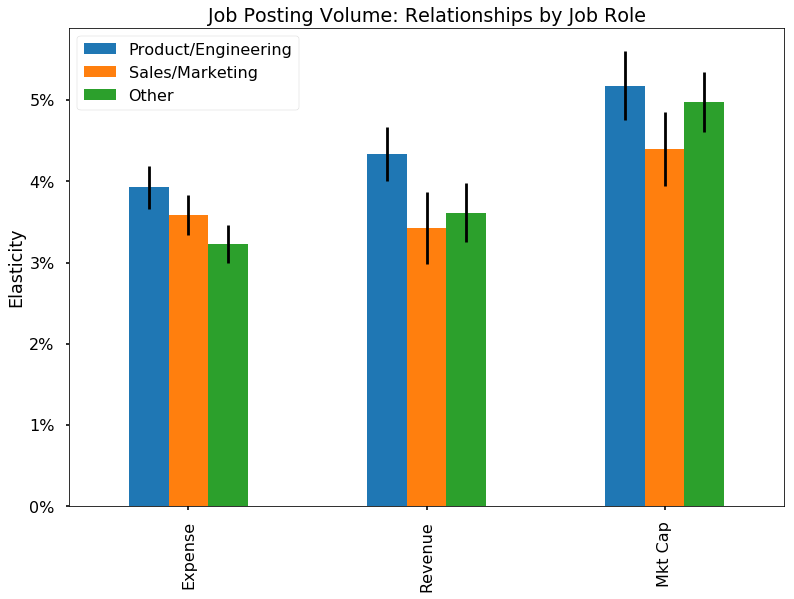

In [13]:
fig, ax = plt.subplots()
plot4.plot.bar(ax=ax,yerr=[err_prod,err_sales,err_other])
ax.set_title('Job Posting Volume: Relationships by Job Role')
ax.set_ylabel('Elasticity')
ax.legend(['Product/Engineering','Sales/Marketing','Other'])

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])